In [1]:
from collections import Counter
from collections import defaultdict
from afinn import Afinn
from __future__ import division
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr
from sklearn import linear_model, metrics
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPRegressor
from sklearn import svm
import os
import json
import math
import string
import random
import wordcloud
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [32]:
courses, targets, departments, distros, starts, profs, titles, durations, word_target_items = [], [], [], [], [], [], [], [], []
dep_map, distro_map, start_map, prof_map, title_map, duration_map, dep_to_enroll, profs_to_ratings  = {}, {}, {}, {}, {}, {}, {}, {}


def prediction_variables_present(course):
    for field in ["summary", "start_time", "end_time", "department", "requirements_met", 
                  "registered", "size", "faculty", "title"]:
        try:
            if course[field] == "n/a":
                return False
        except:
            return False
    return float(course["size"]) > 0


# Input is a course's start time as a string
# Returns number of hours past 8am in decimal format
def time_string_to_float(time):
    time_list = time.split(":")
    hour = int(time_list[0])
    minute = round(float(time_list[1][:2]) / 60, 3)
    ampm = time_list[1][-2:]
    if ampm == "am" or hour == 12:
        hour -= 8
    elif ampm == "pm":
        hour += 4
    return float(str(hour) + str(minute)[1:])


def initialize_data():
    
    # Read in data from Enroll
    path = "Carleton Data - Past Terms"
    for term in os.listdir(path):
        markdown = open(path + "\\" + term).read()
        for course in json.loads(markdown)["course_info"]:
            
            # Exclude courses that aren't appropriate for analysis
            try:
                # Since we're predicting on multiple variables in the same matrix,
                # we'll want to make sure that all of our courses have all of said variables
                has_components = prediction_variables_present(course)

                is_ai = "Argument & Inquiry Seminar" in course["requirements_met"].split("\n")
                is_pe = course["department"] == "PE"
                
                lab_in_title = "Lab" in course["title"]
                is_music = course["department"] == "MUSC"
                six_credits = course["credits"][0] == "6"
                is_lab = lab_in_title and not is_music and not six_credits
                
                if has_components and not is_lab and not is_ai and not is_pe:
                    courses.append(course)
            except:
                pass
    targets.extend([float(course["registered"]) / float(course["size"]) for course in courses])
    
    # Read in data from RateMyProfessors
    markdown = open("RatingsData.json").read()
    for prof in json.loads(markdown)["ratings"]:
        first = prof["teacherfirstname_t"]
        last = prof["teacherlastname_t"]
        rating = prof["averageratingscore_rf"]
        num_ratings = prof["total_number_of_ratings_i"]
        profs.append((first, last, rating, num_ratings))
    profs.sort(key = lambda prof : prof[3])
    profs.sort(key = lambda prof : prof[2])

initialize_data()

In [3]:
print "\n===== Initial analysis =====\n"
print "Number of courses:", len(courses)
print "Number of courses filled to capacity:", len([t for t in targets if t >= 1])
print "Average enrollment (allowing targets greater than 1):", sum(targets) / len(targets), "\n\n"


===== Initial analysis =====

Number of courses: 4220
Number of courses filled to capacity: 969
Average enrollment (allowing targets greater than 1): 0.768114573304 




===== Average Course Enrollment by Department =====

ARTS 1.026 PSYC 1.002 CGSC 0.966 CS 0.955 CAMS 0.954 BIOL 0.947 GEOL 0.942 MATH 0.872 THEA 0.871 IDSC 0.857 PHYS 0.825 CHEM 0.814 WGST 0.812 ECON 0.806 ASTR 0.8 EUST 0.796 POSC 0.79 ENGL 0.772 ENTS 0.751 LING 0.749 SOAN 0.74 ARTH 0.734 SPAN 0.731 CLAS 0.725 AFAM 0.716 ARCN 0.716 PHIL 0.707 AMST 0.702 EDUC 0.69 ASLN 0.687 HIST 0.675 RELG 0.675 FREN 0.663 CHIN 0.659 CCST 0.606 DANC 0.596 LCST 0.555 ARBC 0.542 MUSC 0.521 JAPN 0.474 GERM 0.454 RUSS 0.449 ASST 0.44 LTAM 0.434 HEBR 0.28 MELA 0.25 LATN 0.24 GRK 0.215 




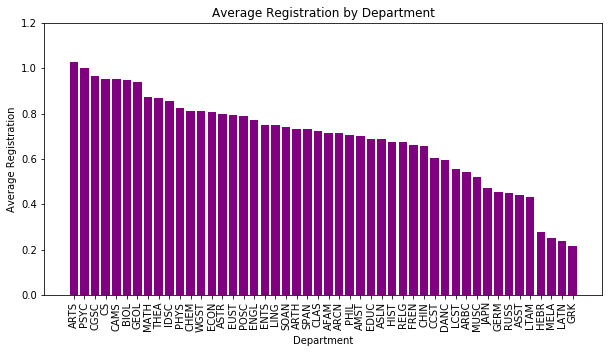

In [4]:
# Construct department data structures
department_set = {course["department"] for course in courses}
departments.extend(sorted(department_set))
for i, dep in enumerate(departments):
    dep_map[dep] = i

# Analyze average course enrollment rate by department
enrollment_by_dep = []
for dep in departments:
    dep_targets = [targets[i] for i, course in enumerate(courses) if course["department"] == dep]
    enrollment_by_dep.append((dep, sum(dep_targets) / len(dep_targets)))
enrollment_by_dep.sort(key = lambda x : x[1], reverse = True)
print "===== Average Course Enrollment by Department =====\n"
averages, deps = [], []
for dep, enroll_rate in enrollment_by_dep:
    dep_to_enroll[dep] = enroll_rate
    deps.append(dep)
    averages.append(enroll_rate)
    print dep, round(enroll_rate, 3),
print "\n\n"


pairs = zip(deps, averages)
pairs.sort(key = lambda x: x[1], reverse = True)
sorted_departments, sorted_targets = zip(*pairs)

fig = plt.figure(figsize=(10,5))
x_ticks = np.arange(len(sorted_departments))
averages = dep_to_enroll.values().sort(reverse = True)
plt.bar(x_ticks, sorted_targets, align='center', color="purple")
plt.xticks(x_ticks, sorted_departments)

plt.xticks(rotation='vertical')
plt.ylim([0, 1.2])
plt.title("Average Registration by Department")
plt.xlabel("Department")
plt.ylabel("Average Registration")
plt.show()


===== Average Course Enrollment by Distro =====

CL 1.083 Science with Lab Component 0.925 Formal or Statistical Reasoning 0.882 Quantitative Reasoning 0.856 Social Inquiry 0.795 Intercultural Domestic Studies 0.793 Writing Rich 2 0.748 Literary/Artistic Analysis 0.7 Humanistic Inquiry 0.684 International Studies 0.682 Arts Practice 0.674 




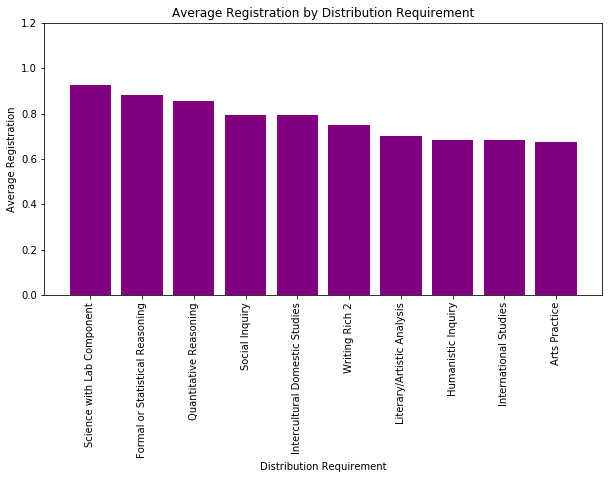

In [5]:
# Construct distro data structures
distro_set = set()
for course in courses:
    for distro in course["requirements_met"].split("\n"):
        if distro:
            distro_set.add(distro)
distros.extend(sorted(distro_set))
for i, distro in enumerate(distros):
    distro_map[distro] = i

# Analyze average course enrollment rate by distro
enrollment_by_distro = []
for distro in distros:
    distro_targets = [targets[i] for i, course in enumerate(courses) if distro in course["requirements_met"].split("\n")]
    enrollment_by_distro.append((distro, sum(distro_targets) / len(distro_targets)))
enrollment_by_distro.sort(key = lambda x : x[1], reverse = True)
print "===== Average Course Enrollment by Distro =====\n"
averages, distros = [], []
for distro, enroll_rate in enrollment_by_distro:
    if distro != 'CL':
        distros.append(distro)
        averages.append(enroll_rate)
    print distro, round(enroll_rate, 3),
print "\n\n"

pairs = zip(distros, averages)
pairs.sort(key = lambda x: x[1], reverse = True)
sorted_distros, sorted_targets = zip(*pairs)

fig = plt.figure(figsize=(10,5))
x_ticks = np.arange(len(sorted_distros))
averages = dep_to_enroll.values().sort(reverse = True)
plt.bar(x_ticks, sorted_targets, align='center', color="purple")
plt.xticks(x_ticks, sorted_distros)

plt.xticks(rotation='vertical')
plt.ylim([0, 1.2])
plt.title("Average Registration by Distribution Requirement")
plt.xlabel("Distribution Requirement")
plt.ylabel("Average Registration")
plt.show()

===== Average Course Enrollment by Start (hours after 8am : enrollment) =====






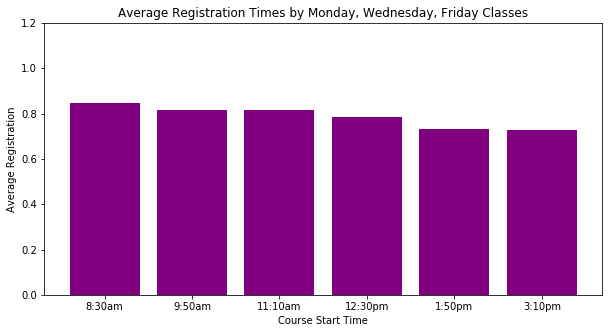

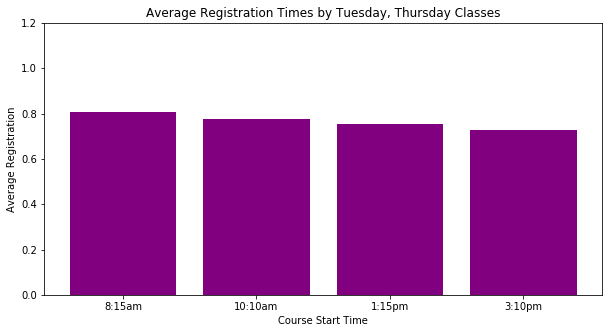

In [6]:
# Construct start time data structures
start_set = {time_string_to_float(course["start_time"]) for course in courses}
starts.extend(start_set)
for i, start in enumerate(starts):
    start_map[start] = i

# Analyze average course enrollment rate by start time
enrollment_by_start = []
for start in starts:
    start_targets = [targets[i] for i, course in enumerate(courses) if start == time_string_to_float(course["start_time"])]
    enrollment_by_start.append((start, sum(start_targets) / len(start_targets)))
enrollment_by_start.sort(key = lambda x : x[0], reverse = True)
print "===== Average Course Enrollment by Start (hours after 8am : enrollment) =====\n"
MWF, MWF_avg, TT, TT_avg = [], [], [], []
for start, enroll_rate in enrollment_by_start:
    if start in [.5, 1.833, 3.167, 4.5, 5.833, 7.167]:
        MWF.append(start)
        MWF_avg.append(enroll_rate)
    if start in [.25, 2.167, 5.25, 7.167]:
        TT.append(start)
        TT_avg.append(enroll_rate)
#     print start, round(enroll_rate, 3)
print "\n\n"

pairs = zip(MWF, MWF_avg)
pairs.sort(key = lambda x: x[1], reverse = True)
sorted_MWF, sorted_targets = zip(*pairs)

fig = plt.figure(figsize=(10,5))
x_ticks = np.arange(len(sorted_MWF))
averages = dep_to_enroll.values().sort(reverse = True)
plt.bar(x_ticks, sorted_targets, align='center', color="purple")
plt.xticks(x_ticks, ['8:30am', '9:50am', '11:10am', '12:30pm', '1:50pm', '3:10pm'])

plt.ylim([0, 1.2])
plt.title("Average Registration Times by Monday, Wednesday, Friday Classes")
plt.xlabel("Course Start Time")
plt.ylabel("Average Registration")
plt.show()


pairs = zip(TT, TT_avg)
pairs.sort(key = lambda x: x[1], reverse = True)
sorted_TT, sorted_targets = zip(*pairs)

fig = plt.figure(figsize=(10,5))
x_ticks = np.arange(len(sorted_TT))
averages = dep_to_enroll.values().sort(reverse = True)
plt.bar(x_ticks, sorted_targets, align='center', color="purple")
plt.xticks(x_ticks,['8:15am', '10:10am', '1:15pm', '3:10pm'])

plt.ylim([0, 1.2])
plt.title("Average Registration Times by Tuesday, Thursday Classes")
plt.xlabel("Course Start Time")
plt.ylabel("Average Registration")
plt.show()

===== Enrollment for Highest-Rated Professors =====



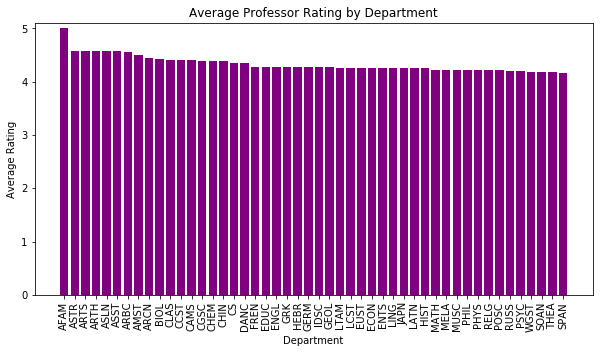

RELG Asuka  Sango 5.0 11 0.681333333333
FREN Cathy  Yandell 5.0 9 0.779777777778
SOAN Constanza Ocampo-Raeder 5.0 9 0.878222222222
ENGL Nancy J Cho 5.0 9 0.741704545455
AMST Adriana  Estill 5.0 8 0.863908045977
ENGL Elizabeth  McKinsey 5.0 8 0.69
RELG Sonja G Anderson 5.0 8 0.614444444444
AFAM Kevin A Wolfe 5.0 5 0.736296296296
ARTH Kathleen M Ryor 4.94 8 0.697777777778
ENGL George G Shuffelton 4.9 10 0.807619047619
PSYC Julia F Strand 4.9 10 1.06780719281
CAMS Stacy N Beckwith 4.9 7 0.45
SOAN Brian W Fuller 4.9 5 0.825
ARTS Daniel P Bruggeman 4.9 5 0.915455304929
CHEM Steven M Drew 4.86 7 0.892270837747
WGST Shana L Sippy 4.84 19 0.688133333333
FREN Scott D Carpenter 4.83 9 0.687125
ECON Jenny  Bourne 4.8 35 0.875277777778
POSC Dev Gupta 4.8 18 0.910733182162
MATH Eric S Egge 4.8 15 0.950699588477
POSC Laurence D Cooper 4.8 12 0.661234567901
MUSC Melinda  Russell 4.8 12 0.865724637681
CHEM Matt Whited 4.8 9 0.764675828048
PHIL Jason A Decker 4.8 8 0.87037037037
ASTR Frank T McNally 4.

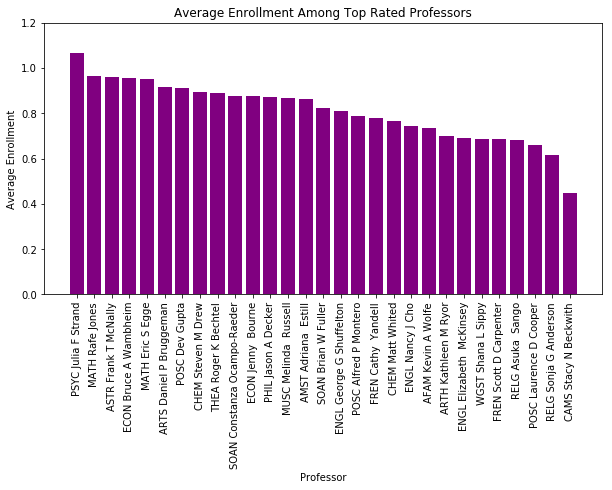

In [7]:
def get_average(a):
    total = 0
    mean = 0
    for i in a:
        total += i
    if len(a) > 0:
        mean = total *1.0 / len(a)
    return mean
    

# Construct prof data structures
for course in courses:
    for prof in profs:
        if prof[0] in course["faculty"] and prof[1] in course["faculty"]:
            # Enroll name : (rating, number of ratings, department)
            profs_to_ratings[course["faculty"]] = (prof[2], prof[3], course["department"])
profs_to_targets = {}
for prof in profs_to_ratings.keys():
    prof_targets = [targets[i] for i, course in enumerate(courses) if course["faculty"] == prof]
    profs_to_targets[prof] = sum(prof_targets) / len(prof_targets)
prof_set = {course["faculty"] for course in courses}
for i, prof in enumerate(list(prof_set)):
    prof_map[prof] = i


# Find average enrollments of highest-rated profs
prof_items = profs_to_ratings.items()
prof_items.sort()
prof_items.sort(key = lambda prof : prof[1][1], reverse = True)
prof_items.sort(key = lambda prof : prof[1][0], reverse = True)
print "===== Enrollment for Highest-Rated Professors =====\n"
averages, all_departments, ratings = [], [], []
for department in departments:
    for prof in prof_items:
        if str(prof[1][2]) == department:
            ratings.append(prof[1][0])
    averages.append(get_average(ratings))
    all_departments.append(department)
    
pairs = zip(all_departments, averages)
pairs.sort(key = lambda x: x[1], reverse = True)
sorted_deps, sorted_targets = zip(*pairs)

fig = plt.figure(figsize=(10,5))
x_ticks = np.arange(len(sorted_deps))
plt.bar(x_ticks, sorted_targets, align='center', color="purple")
plt.xticks(x_ticks, sorted_deps)

plt.xticks(rotation='vertical')
plt.ylim([0, 5.1])
plt.title("Average Professor Rating by Department")
plt.xlabel("Department")
plt.ylabel("Average Rating")
plt.show()    
    
dep_names, enrollments = [], []
for prof in prof_items:
    # Find profs with rating > 4.7 and number of ratings > 4
    if prof[1][0] > 4.7 and prof[1][1] > 4 and len(prof[0].split(",")) == 1:
        dep_names.append((str(prof[1][2]) +' '+ str(prof[0][1:])))
        enrollments.append(profs_to_targets[prof[0]])
        # Print department, Enroll name, rating, number of ratings, average enrollment
        print prof[1][2], prof[0][1:], prof[1][0], prof[1][1], profs_to_targets[prof[0]]
print "\n\n"

pairs = zip(dep_names, enrollments)
pairs.sort(key = lambda x: x[1], reverse = True)
sorted_names, sorted_targets = zip(*pairs)

fig = plt.figure(figsize=(10,5))
x_ticks = np.arange(len(sorted_names))
plt.bar(x_ticks, sorted_targets, align='center', color="purple")
plt.xticks(x_ticks, sorted_names)

plt.xticks(rotation='vertical')
plt.ylim([0, 1.2])
plt.title("Average Enrollment Among Top Rated Professors")
plt.xlabel("Professor")
plt.ylabel("Average Enrollment")
plt.show()

In [8]:
# Construct course data structures
title_set = {course["title"] for course in courses}
titles.extend(sorted(title_set))
for i, title in enumerate(titles):
    title_map[title] = i

# Find most-enrolled course by department
enrollment_by_title = defaultdict(list)
for title in titles:
    title_targets = []
    department = ""
    for i, course in enumerate(courses):
        if course["title"] == title:
            title_targets.append(targets[i])
            department = course["department"]
    enrollment_by_title[department].append((title, sum(title_targets) / len(title_targets)))
print "===== Most-Enrolled Course by Department =====\n"
for pair in enrollment_by_title.items():
    most_popular = pair[1]
    most_popular.sort(key = lambda x : x[1], reverse = True)
    print pair[0], most_popular[0]
print "\n"

===== Most-Enrolled Course by Department =====

ENGL (u' Telling Your American Story ', 1.8)
EUST (u' The Age of Cathedrals ', 0.9333333333333333)
MUSC (u' Rock Lab ', 1.125)
ECON (u' Intermediate Price Theory ', 1.0091666666666668)
THEA (u' The Speaking Voice ', 1.2013888888888886)
IDSC (u' Student Conversations about Diversity and Community ', 1.011111111111111)
ENTS (u' The Science of the Earth System ', 1.0)
CHIN (u' The Taoist Way of Health and Longevity: ', 1.3416666666666668)
PSYC (u' Sleep and Dreaming ', 1.427142857142857)
LING (u' Topics in Morphology ', 1.0)
ARCN (u' Archaeological Methods ', 1.15)
CHEM (u' Organic Chemistry I ', 0.9851579016913318)
ARTS (u' Printmaking ', 2.2)
AFAM (u' An Introduction to African American Culture, Practice, and Religion ', 1.0)
CAMS (u' Visual Studies Seminar ', 1.3666666666666665)
PHIL (u' Irrationality ', 1.1333333333333333)
CGSC (u' Revolutions in Mind:  An Introduction to Cognitive Science ', 0.9)
BIOL (u' Behavioral Ecology ', 1.4583333

In [9]:

# Construct course duration data structures
duration_set = {round(time_string_to_float(course["end_time"]) - time_string_to_float(course["start_time"]), 2) for course in courses}
durations = sorted(duration_set)
for i, duration in enumerate(durations):
    duration_map[duration] = i

# Analyze enrollment by course duration
enrollment_by_duration = []
for dur in durations:
    dur_targets = []
    for i, course in enumerate(courses):
        if round(time_string_to_float(course["end_time"]) - time_string_to_float(course["start_time"]), 2) == dur:
            dur_targets.append(targets[i])
    enrollment_by_duration.append((dur, sum(dur_targets) / len(dur_targets)))
enrollment_by_duration.sort(key = lambda x : x[0], reverse = True)
print "===== Average Course Enrollment by Course Duration (hours : enrollment) =====\n"
for dur, enroll_rate in enrollment_by_duration:
    print dur, round(enroll_rate, 3)
print "\n"

===== Average Course Enrollment by Course Duration (hours : enrollment) =====

4.0 0.738
3.75 0.222
3.67 0.4
3.0 0.864
2.5 1.013
2.33 1.325
2.0 0.454
1.83 0.372
1.75 0.776
1.67 0.954
1.5 0.388
1.33 0.783
1.17 0.79
1.08 0.592
1.0 0.505
0.98 0.45
0.5 0.108




===== Average Enrollment by Description Sentiment (upper bound : # courses : enrollment) =====

-0.18 21 0.566349206349
-0.16 24 0.664950980392
0.12 4019 0.769694834874
0.16 96 0.788422035481
0.18 17 0.831428571429
0.24 32 0.72703125

Most course descriptions feature a slightly positive sentiment. No observable enrollment pattern.




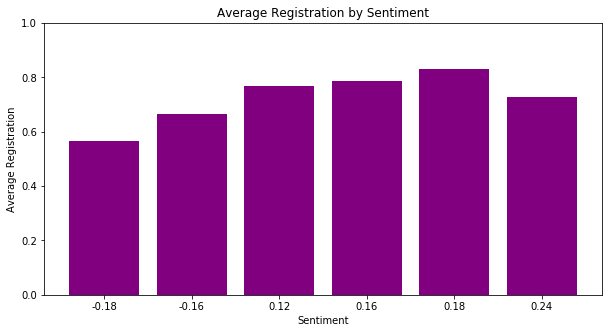

In [10]:
# Analyze course description sentiment
afinn = Afinn()
sentiment_to_targets = defaultdict(list)
upper_bounds = [-.18, -.16, .12, -.08, -.04, 0, .04, .08, .12, .16, .18, .24]
for i, course in enumerate(courses):
    sentiment = afinn.score(course["summary"]) / len(course["summary"].split(" "))
    for bound in upper_bounds:
        if sentiment < bound:
            sentiment_to_targets[bound].append(targets[i])
            break
print "===== Average Enrollment by Description Sentiment (upper bound : # courses : enrollment) =====\n"
averages, buckets = [], []
for item in sorted(sentiment_to_targets.items()):
    buckets.append(item[0])
    averages.append(sum(item[1]) / len(item[1]))
    print item[0], len(item[1]), sum(item[1]) / len(item[1])
print "\nMost course descriptions feature a slightly positive sentiment. No observable enrollment pattern.\n\n"

pairs = zip(buckets, averages)
pairs.sort(key = lambda x: x[0])
sorted_buckets, sorted_targets = zip(*pairs)

fig = plt.figure(figsize=(10,5))
x_ticks = np.arange(len(sorted_buckets))
averages = dep_to_enroll.values().sort(reverse = True)
plt.bar(x_ticks, sorted_targets, align='center', color="purple")
plt.xticks(x_ticks, sorted_buckets)

plt.ylim([0, 1])
plt.title("Average Registration by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Registration")
plt.show()


===== Average Enrollment by Description Length (upper bound : # courses : enrollment) =====

50 47 0.596063829787
100 76 0.589905185759
150 224 0.69255952381
200 241 0.708988493532
250 192 0.76186650827
300 296 0.79424292393
400 578 0.77188020969
500 654 0.801667854718
600 892 0.795681211398
700 776 0.758584401802
800 192 0.806036726754
900 21 0.797858699035
1000 13 0.732948717949
1100 11 0.62696969697
1200 3 0.841666666667
1300 2 0.555555555556
1400 2 0.4




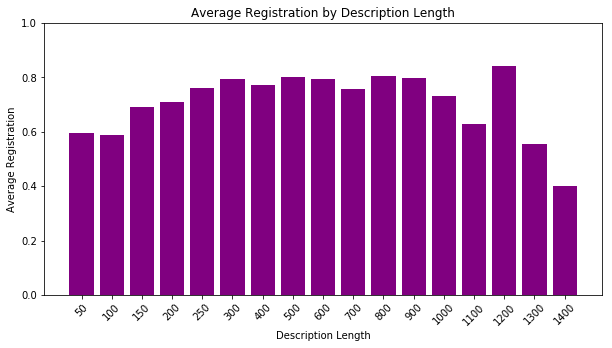

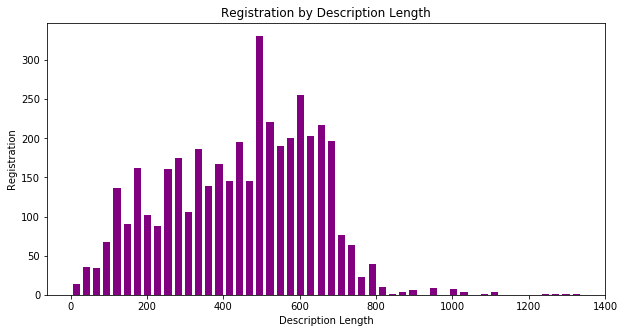

In [42]:
# Analyze course description length
lengths_to_targets = defaultdict(list)
all_summaries, enrollments = [], []
upper_bounds = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400]
for i, course in enumerate(courses):
    l = len(course["summary"])
    all_summaries.append(l)
    enrollments.append(course['registered'])
    for bound in upper_bounds:
        if l < bound:
            lengths_to_targets[bound].append(targets[i])
            break
print "===== Average Enrollment by Description Length (upper bound : # courses : enrollment) =====\n"
averages, buckets = [], []
for item in sorted(lengths_to_targets.items()):
    buckets.append(item[0])
    averages.append(sum(item[1]) / len(item[1]))
    print item[0], len(item[1]), sum(item[1]) / len(item[1])
print "\n"


pairs = zip(buckets, averages)
pairs.sort(key = lambda x: x[0])
sorted_buckets, sorted_targets = zip(*pairs)

fig = plt.figure(figsize=(10,5))
x_ticks = np.arange(len(sorted_buckets))
averages = dep_to_enroll.values().sort(reverse = True)
plt.bar(x_ticks, sorted_targets, align='center', color="purple")
plt.xticks(x_ticks, sorted_buckets)

plt.xticks(rotation=45)
plt.ylim([0, 1])
plt.title("Average Registration by Description Length")
plt.xlabel("Description Length")
plt.ylabel("Average Registration")
plt.show()

# %matplotlib inline
# x = buckets
# plt.hist(x, bins=18, color = 'purple')
# plt.ylabel('Probability');


x = all_summaries
hist, bins = np.histogram(x, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
fig = plt.figure(figsize=(10,5))
plt.bar(center, hist, align='center', width=width, color = 'purple')
plt.title("Registration by Description Length")
plt.xlabel("Description Length")
plt.ylabel("Registration")
plt.show()

===== Average Enrollment by Description Key Word (word : # descriptions : enrollment) =====

team 21 0.912333024119
data 308 0.907282223195
collab 36 0.896069807553
food 23 0.860206243032
middle east 19 0.849473684211
introduction 687 0.84632818504
essay 98 0.839407596372
sex 115 0.833242753623
science 265 0.829877998604
project 285 0.826660479651
assignment 124 0.809636850341
internet 42 0.800462184874
non-fiction 16 0.780416666667
advanced 261 0.773772014553
gender 219 0.763150684932
america 413 0.747392587235
europe 134 0.684907604833
novel 115 0.653445511011
asia 77 0.594935064935
love 27 0.586666666667
africa 151 0.567421948912
democracy 29 0.541510673235




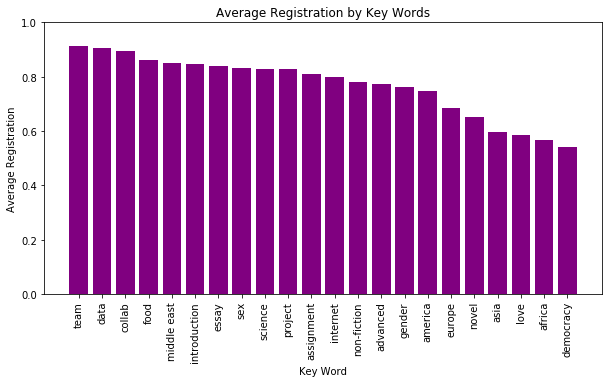

In [12]:
# Analyze key words in course descriptions
words_to_targets = defaultdict(list)
key_words = ["sex", "gender", "collab", "internet", "food", "introduction", "asia", "europe", "africa", "middle east", "america", "advanced", "essay", "assignment", "science", "novel", "non-fiction", "data", "love", "democracy", "project", "team"]
for word in key_words:
    for i, course in enumerate(courses):
        if word in course["summary"].lower():
            words_to_targets[word].append(targets[i])
word_list1 = words_to_targets["non-fiction"]
word_list2 = words_to_targets["novel"]
print "===== Average Enrollment by Description Key Word (word : # descriptions : enrollment) =====\n"
word_target_items = words_to_targets.items()
word_target_items.sort(key = lambda x : sum(x[1]) / len(x[1]), reverse = True)
averages, words = [], []
for item in word_target_items:
    averages.append(sum(item[1]) / len(item[1]))
    words.append(item[0])
    print item[0], len(item[1]), sum(item[1]) / len(item[1])
print "\n"

pairs = zip(words, averages)
pairs.sort(key = lambda x: x[1], reverse = True)
sorted_words, sorted_targets = zip(*pairs)

fig = plt.figure(figsize=(10,5))
x_ticks = np.arange(len(sorted_words))
averages = dep_to_enroll.values().sort(reverse = True)
plt.bar(x_ticks, sorted_targets, align='center', color="purple")
plt.xticks(x_ticks, sorted_words)

plt.xticks(rotation='vertical')
plt.ylim([0, 1])
plt.title("Average Registration by Key Words")
plt.xlabel("Key Word")
plt.ylabel("Average Registration")
plt.show()


In [34]:
sig_05= []
    
def year_courses(i):
    year = []
    for course in courses:
        if str(course["term"]).startswith(i):
            year.append(course)
    return year

def get_averages(y1, department):
    first = year_courses(y1)
    dep = []
    for course in first:
        if course['department'] == department:
            dep.append((int(course["registered"]) * 1.0 / int(course["size"])))
    return dep
# Takes in two years and a department to determine the difference between means
def compare_means(y1, y2, department):
    a = get_averages(y1, department)
    b = get_averages(y2, department)
    if len(a) >1 and len(b) >1:
        a = np.array(a)
        b = np.array(b)

        t, p = ttest_ind(a, b, equal_var=False)
    #     print("ttest_ind:            t = %g  p = %g" % (t, p))

        abar = a.mean()
        avar = a.var(ddof=1)
        na = a.size
        adof = na - 1

        bbar = b.mean()
        bvar = b.var(ddof=1)
        nb = b.size
        bdof = nb - 1    

        t2, p2 = ttest_ind_from_stats(abar, np.sqrt(avar), na,
                                  bbar, np.sqrt(bvar), nb,
                                  equal_var=False)
    #     print("ttest_ind_from_stats: t = %g  p = %g" % (t2, p2))

        tf = (abar - bbar) / np.sqrt(avar/na + bvar/nb)
        dof = (avar/na + bvar/nb)**2 / (avar**2/(na**2*adof) + bvar**2/(nb**2*bdof))
        pf = 2*stdtr(dof, -np.abs(tf))

    #     print("formula:              t = %g  p = %g" % (tf, pf))

        if p < 0.05:
            sig_05.append(department)
            print department
            print str('20'+ y1), "mean =", str(abar)
            print str('20'+ y2), "mean =", str(bbar)
            print("ttest_ind_from_stats: t = %g  p = %g" % (t2, p2))
            if abar > bbar:
                print "Decrease in Average Enrollment"
            elif abar == bbar:
                print "No change in Average Enrollment"
            else:
                print "Increase in Average Enrollment"


for department in departments:
    compare_means('12', '17', department)
# print sig_05


In [14]:
course_list = []
for course in courses:
    course_list.append(int(course['registered']) *1.0/int(course['size']))

def compare_means(list1, list2):
    a = np.array(list1)
    b = np.array(list2)
    
    t, p = ttest_ind(a, b, equal_var=False)
    print("ttest_ind:            t = %g  p = %g" % (t, p))
    
    abar = a.mean()
    avar = a.var(ddof=1)
    na = a.size
    adof = na - 1

    bbar = b.mean()
    bvar = b.var(ddof=1)
    nb = b.size
    bdof = nb - 1    
    
    t2, p2 = ttest_ind_from_stats(abar, np.sqrt(avar), na,
                              bbar, np.sqrt(bvar), nb,
                              equal_var=False)
    print("ttest_ind_from_stats: t = %g  p = %g" % (t2, p2))

    tf = (abar - bbar) / np.sqrt(avar/na + bvar/nb)
    dof = (avar/na + bvar/nb)**2 / (avar**2/(na**2*adof) + bvar**2/(nb**2*bdof))
    pf = 2*stdtr(dof, -np.abs(tf))

    print("formula:              t = %g  p = %g" % (tf, pf))
      
   
    
    if abar > bbar:
        print "Decrease in Average Enrollment"
    elif abar == bbar:
        print "No change in Average Enrollment"
    else:
        print "Increase in Average Enrollment"
    
    if p < 0.05:
        sig_05.append(department)
        

compare_means(word_list1, word_list2)

ttest_ind:            t = 1.76296  p = 0.0939037
ttest_ind_from_stats: t = 1.76296  p = 0.0939037
formula:              t = 1.76296  p = 0.0939037
Decrease in Average Enrollment


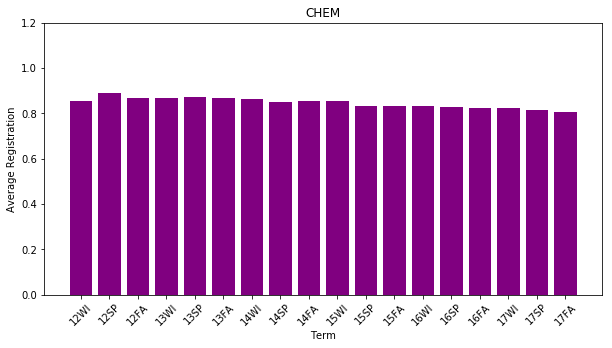

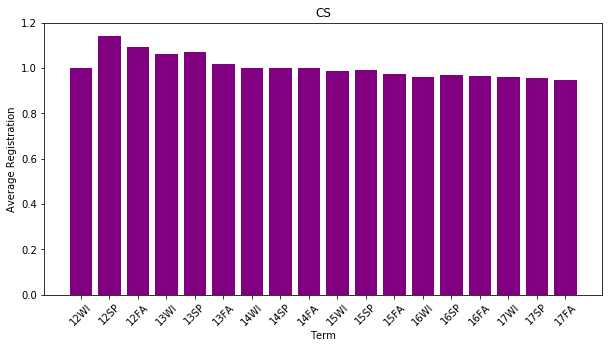

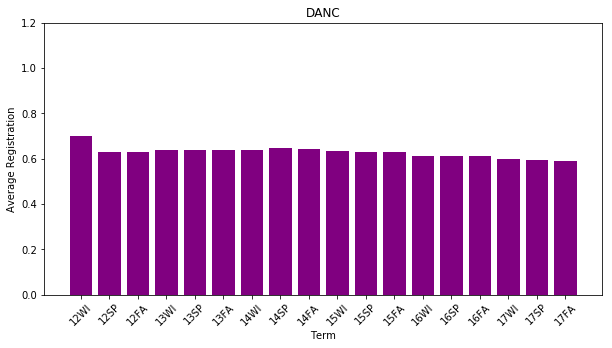

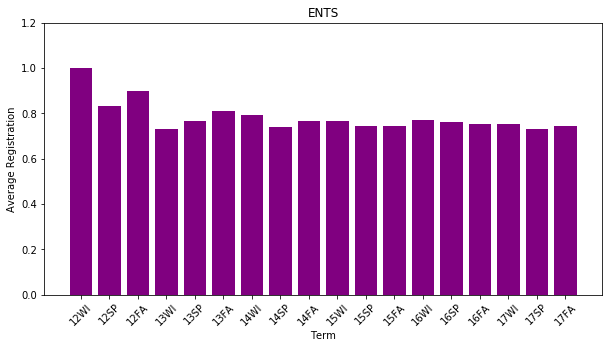

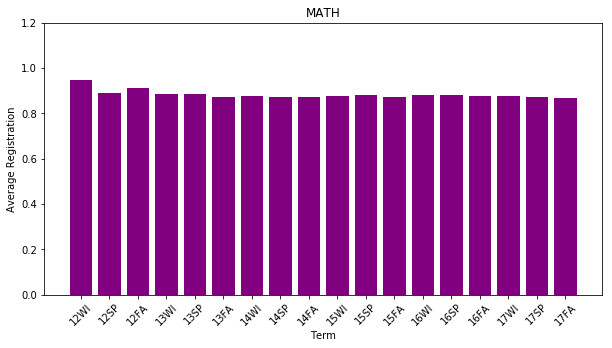

In [15]:
terms = ['12WI', '12SP', '12FA', '13WI', '13SP', '13FA', '14WI', '14SP', '14FA', '15WI', '15SP', '15FA', '16WI', '16SP', '16FA', '17WI', '17SP', '17FA']

def find_average(a):
    all_averages, size, count, average = 0, 0, 0, 0
    for course in a:
        all_averages += (int(course["registered"]) * 1.0 / int(course["size"]))
        count = count + 1
    if count >0:
        average = int(all_averages) * 1.0 / count
    return average

for department in sig_05:
    averages, subject = [], []
    for term in terms:
        for course in courses:
            if course['term'] == term and course['department'] == department:
                subject.append(course)

        averages.append(find_average(subject))
            
    pairs = zip(terms, averages)
    sorted_terms, sorted_targets = zip(*pairs)

    fig = plt.figure(figsize=(10,5))
    x_ticks = np.arange(len(sorted_terms))
    averages = dep_to_enroll.values().sort(reverse = True)
    plt.bar(x_ticks, sorted_targets, align='center', color="purple")
    plt.xticks(x_ticks, sorted_terms)

    plt.xticks(rotation=45)
    plt.ylim([0, 1.2])
    plt.title(department)
    plt.xlabel("Term")
    plt.ylabel("Average Registration")
    plt.show()



In [16]:
def test_model(matrix, model):

    test_errors = []

    # Ten iterations of 80/20 cross-validation
    for _ in range(10):
    
        # Randomly partition about 80% of the data for training and the remaining for testing
        training_matrix, training_targets, test_matrix, test_targets = [], [], [], []
        for i in range(len(targets)):
            if random.random() < .8:
                training_matrix.append(matrix[i])
                training_targets.append(targets[i])
            else:
                test_matrix.append(matrix[i])
                test_targets.append(targets[i])

        # Train and predict on test data
        model.fit(training_matrix, training_targets)
        test_predictions = model.predict(test_matrix)
        test_errors.append(metrics.mean_absolute_error(test_targets, test_predictions))
    
    print "Minimum mean error over ten models:", min(test_errors), "\n\n"


def predict():

    # Construct training matrix
    matrix = np.zeros((len(courses), 11))
    for i, course in enumerate(courses):
        
        # Column 0: Department classification
        # Single-var random tree absolute error: .190
        matrix[i][0] = dep_map[course["department"]] 
        
        # Columns 1 - 4: Possible distros
        # Single-var random tree absolute error: .217
        course_distros = course["requirements_met"].split("\n")
        course_distros = filter(lambda distro : distro, course_distros)
        for j, distro in enumerate(course_distros):
            matrix[i][1 + j] = distro_map[distro] 

        # Column 5: Start time
        # Single-var random tree absolute error: .214
        matrix[i][5] = start_map[time_string_to_float(course["start_time"])] 

        # Columns 6 and 7: RateMyProfessors data
        try:
            prof = profs_to_ratings[course["faculty"]]
            matrix[i][6] = prof[0] # Single-var linreg error: .224
            matrix[i][7] = prof[1] # Single-var linreg error: .232
        except:
            pass

        # Column 8: Course title
        # Single-var random tree absolute error: .183
        matrix[i][8] = title_map[course["title"]]

        # Column 9: Course duration
        # Single-var linreg error: .231
        matrix[i][9] = round(time_string_to_float(course["end_time"]) - time_string_to_float(course["start_time"]), 2) 

        # Column 10: Professor
        # Single-var random tree absolute error: .184
        matrix[i][10] = prof_map[course["faculty"]]

    # Standardize the data: center columns at 0 and divide by variance
    for i in range(len(matrix[0])):
        column = np.array(matrix)[:, i]
        column_mean = sum(column) / len(column)
        column_std = np.std(column)
        for j in range(len(matrix)):
            matrix[j][i] -= column_mean
            matrix[j][i] /= column_std

    print "===== Random Forest Regressor Results =====\n"
    test_model(matrix, RandomForestRegressor(n_estimators = 50, oob_score = True))

    print "===== Multilayer Perceptron Results =====\n"
    test_model(matrix, MLPRegressor(hidden_layer_sizes=(100, 10)))

    print "===== Support Vector Machine Results =====\n"
    test_model(matrix, svm.SVR())
    
predict()

===== Random Forest Regressor Results =====

Minimum mean error over ten models: 0.164111520121 


===== Multilayer Perceptron Results =====

Minimum mean error over ten models: 0.189714727475 


===== Support Vector Machine Results =====

Minimum mean error over ten models: 0.185968270034 


